In [1]:
# Import needed dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy import stats
import warnings
import missingno as msno
import pyod
import math
import sklearn.naive_bayes as nb
import sklearn.svm as svm
from sklearn.metrics import accuracy_score, classification_report
import pickle
import random
from sklearn.linear_model import LogisticRegression

# For following steps found at: https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pyod.models.combination import average
from pyod.utils.utility import standardizer

warnings.filterwarnings('ignore')
%matplotlib inline

In [61]:
# Read in pre-vectorized data. See my email for an explanation of how I've been doing this

print("Reading...")
titles = pd.read_pickle("./titles_vec.pkl")
traces = pd.read_pickle("./traces_vec.pkl")

#scaler = StandardScaler()
#titles = scaler.fit_transform(titles)
#traces = scaler.fit_transform(traces)

print("Done")

Reading...
Done


In [64]:
# Create the training data from the loaded vectors

# Add trace function
def add_traces(result: list, add_in: list):
    for j in range(0, result.shape[0]):
        result[j] += add_in[j]
    return result

# Generate good data
print("Generate good")
data = []
data_bad = titles.copy()
random.Random(99).shuffle(data_bad)

# Generate values
print("Create final data")
for i in range(0, len(titles)):
    data.append(np.append(titles[i], traces[i]))
    data_bad[i] = np.append(data_bad[i], traces[i])
#    add_traces(data[i], traces[i])
#    add_traces(data_bad[i], traces[i])


Generate good
Create final data


In [65]:
# Convert the data into a proper Panda data frame, with a set of labels to boot

# Based on https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
# Create
X = np.append(data_bad, data, axis=0)
length = len(data)
y = np.zeros(len(X))
for i in range(0, length):
    y[i] = 0
    y[i + length] = 1

X = pd.DataFrame(X)

# Standardize
#X = MinMaxScaler().fit_transform(StandardScaler().fit_transform(X))
X = pd.DataFrame(X)
#y = pd.DataFrame(y)

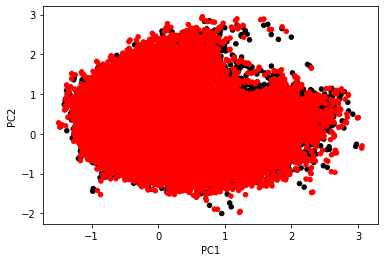

In [66]:
# Split data set and render PCA scatterplot. Here's where things have gone downhill

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

pca = PCA(2)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
x_pca.head()
y_color = np.where(y==1,'red',
            np.where(y==0,'black', 'blue'))
x_pca.plot(kind='scatter', x='PC1', y='PC2', c=y_color)

In [67]:
# Train a basic anomaly detection to remove outliers

# Train sizes
amt1:int = len(X_train)
amt2:int = math.ceil(amt1 * 0.8)
amt3:int = math.ceil(amt1 * 0.6)

# Build models
print(amt1)
print("Train 1")
clf1 = IForest(behaviour="new", max_samples=amt1, random_state=7)
clf1.fit(X_train)

print("Train 2")
clf2 = IForest(behaviour="new", max_samples=amt2, random_state=23)
clf2.fit(X_train)

print("Train 3")
clf3 = IForest(behaviour="new", max_samples=amt3, random_state=2020)
clf3.fit(X_train)

90696
Train 1
Train 2
Train 3


IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=54418, n_estimators=100, n_jobs=1, random_state=2020,
    verbose=0)

In [68]:
# Run the data through the anomaly detection to get anomaly scores

# Once again from https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

# Normalize
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

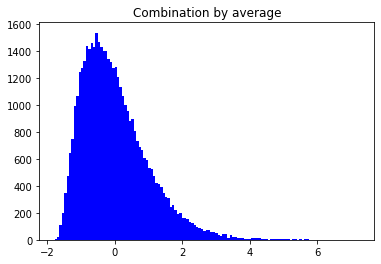

In [69]:
# Display a hitogram of the anomaly scores. For the data set listed here, 3+ appears to be an anomaly

# One more time: from https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08
# Combination by average
y_by_average = average(test_scores_norm)

plt.hist(y_by_average, bins='auto', color='blue')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [70]:
# Run the calculations needed to prepare to filter outliers

# Get copies
cats_avg = average(train_scores_norm)
X_train_cluster = X_train.copy()

# Apply anomaly scores
X_train_cluster["distance"] = cats_avg

# Cluster
X_train_cluster = np.where(X_train_cluster['distance']<4, 0, 1)

In [71]:
# Filter the outliers

toDrop: list = []
for i in range(0, len(X_train_cluster) - 1):
    if X_train_cluster[i]:
        toDrop.append(i)

X_train_filtered: list = X_train.drop(X_train.index[toDrop])
y_train_filtered: list = pd.DataFrame(y_train)
y_train_filtered = y_train_filtered.drop(y_train_filtered.index[toDrop]).to_numpy()

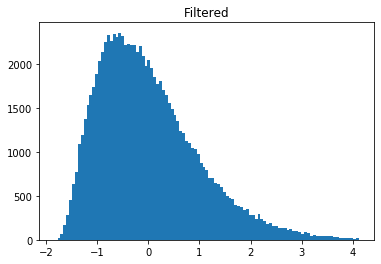

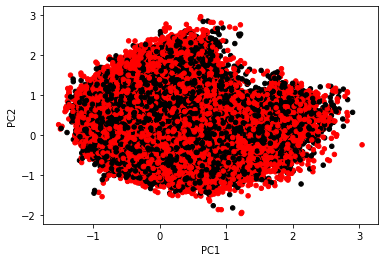

In [72]:
# Verify that the outlier filtering worked, using a histogram and PCA scatterplot

train_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_train_filtered),
                              'clf2': clf2.decision_function(X_train_filtered),
                              'clf3': clf3.decision_function(X_train_filtered) 
                            })
y_by_average = average(standardizer(train_scores))

plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Filtered")
plt.show()

# Graph scatterplot
pca = PCA(2)
x_pca = pca.fit_transform(X_train_filtered)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
x_pca.head()
y_color = np.where(y_train_filtered==1,'red',
            np.where(y_train_filtered==0,'black', 'blue'))
y_color = y_color.flatten()
x_pca.plot(kind='scatter', x='PC1', y='PC2', c=y_color)

In [73]:
# Prepare a basic function to train and display results for a number of Scikit-Learn's approaches 

scaler = MinMaxScaler()
train_data = scaler.fit_transform(X_train)
test_data = scaler.fit_transform(X_test)

def report(actual, prediction):
    print('Accuracy:%.2f%%' % (accuracy_score(actual, prediction) * 100))
    print('Classification Report:')
    print(classification_report(actual, prediction))

def train(test, name: str):
    # Train
    test.fit(train_data, y_train)

    # Predict
    test_prediction = test.predict(test_data)
    train_prediction = test.predict(train_data)
    
    # Report
    print("===============" + name + "===============\n")
    print("Training set:")
    report(y_train, train_prediction)
    print("Test set:")
    report(y_test, test_prediction)

    # Persist classifier to disk
    with open(name, "wb") as out_file:
        pickle.dump(test, out_file)

In [74]:
# Run the tests with a Linear SVC, logistic regression, and a few flavors of Naive Bayes. No non-linear SVMs
# because there is too much high-dimensional data.

# Naive Bayes
train(svm.LinearSVC(random_state=42), "linearsvc.pkl")
train(LogisticRegression(), "reg.pkl")
train(nb.GaussianNB(), "gauss.pkl")
train(nb.MultinomialNB(), "multinomial.pkl")
train(nb.ComplementNB(), "comp.pkl")
train(nb.BernoulliNB(), "bern.pkl")

===============linearsvc.pkl===============

Training set:
Accuracy:51.85%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.34      0.42     45312
         1.0       0.51      0.69      0.59     45384

    accuracy                           0.52     90696
   macro avg       0.52      0.52      0.50     90696
weighted avg       0.52      0.52      0.50     90696

Test set:
Accuracy:49.39%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.42      0.03      0.05     22372
         1.0       0.50      0.96      0.66     22300

    accuracy                           0.49     44672
   macro avg       0.46      0.49      0.35     44672
weighted avg       0.46      0.49      0.35     44672

===============reg.pkl===============

Training set:
Accuracy:51.81%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.51      0.51     4531

In [76]:
# Here down is leftover blocks which I used while trying and failing to detect a pattern in the data

'''
tmp = data.copy()
for i in range(0, len(data_bad)):
    tmp[i] -= data_bad[i]
panda_data = pd.DataFrame(tmp)
sns.catplot(data=panda_data,
            kind='box',
            height=15, aspect=1.5)
plt.show();

panda_data = pd.DataFrame(data)
sns.catplot(data=panda_data,
            kind='box',
            height=15, aspect=1.5)
plt.show()

panda_data = pd.DataFrame(data_bad)
sns.catplot(data=panda_data,
            kind='box',
            height=15, aspect=1.5)
plt.show()
'''

"\ntmp = data.copy()\nfor i in range(0, len(data_bad)):\n    tmp[i] -= data_bad[i]\npanda_data = pd.DataFrame(tmp)\nsns.catplot(data=panda_data,\n            kind='box',\n            height=15, aspect=1.5)\nplt.show();\n\npanda_data = pd.DataFrame(data)\nsns.catplot(data=panda_data,\n            kind='box',\n            height=15, aspect=1.5)\nplt.show()\n\npanda_data = pd.DataFrame(data_bad)\nsns.catplot(data=panda_data,\n            kind='box',\n            height=15, aspect=1.5)\nplt.show()\n"

In [75]:
# Again, leftover blocks which I used while trying and failing to detect a pattern in the data

#correlation matrix
'''
X_hm = X.copy()
X_hm[100] = y

corrmat = X_hm.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
'''

'\nX_hm = X.copy()\nX_hm[100] = y\n\ncorrmat = X_hm.corr()\nf, ax = plt.subplots(figsize=(12, 9))\nsns.heatmap(corrmat, vmax=.8, square=True);\n'